In [1]:
# %% [markdown]
# # Prototype Pipeline for 8-qubit QFT on Penning Trap
#
# 1. Load Penning-trap graph  
# 2. Count node types  
# 3. Pathfinding utils  
# 4. Call `compiler01()`  
# 5. Verify rules & compute fidelity  
# 6. Visualize as GIF

# 0. Setup imports
import sys, os

# Compute absolute paths
ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))      # project root
SRC  = os.path.join(ROOT, "src")                             # src directory

# Put 'src/' on sys.path so that 'import trap' works
sys.path.insert(0, SRC)

# (Optional) also ensure project root is on path if you ever need run scripts from project root
# sys.path.insert(0, ROOT)

import networkx as nx
from trap import create_trap_graph
from verifier import verifier
from fidelity import fidelity

/Users/nd/OS/Code/quantum-hackaton-2025/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:

# %% [markdown]
# ## 1. Load trap graph

# %% 
G = create_trap_graph()
print(f"Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")


Graph: 64 nodes, 87 edges


In [3]:

# %% [markdown]
# ## 2. Count node types

# %% 
standard = [n for n,d in G.nodes(data=True) if d["type"]=="standard"]
interaction = [n for n,d in G.nodes(data=True) if d["type"]=="interaction"]
idle = [n for n,d in G.nodes(data=True) if d["type"]=="idle"]
print(f"Standard:   {len(standard)}")
print(f"Interaction:{len(interaction)}")
print(f"Idle:       {len(idle)}")


Standard:   29
Interaction:6
Idle:       29


In [4]:

# %% [markdown]
# ## 3. Pathfinding utilities

# %% 
from functools import lru_cache

@lru_cache(None)
def shortest_path(a,b): return nx.shortest_path(G,a,b)
@lru_cache(None)
def shortest_distance(a,b): return nx.shortest_path_length(G,a,b)


In [5]:

# %% [markdown]
# ## 4. Placeholder compiler – `compiler01()`

# %%
# new
from compiler.compiler01 import compiler01

# verbose=True prints one line for every 2-qubit batch
positions, gates = compiler01(verbose=True)
print("T=0 positions:", positions[0])
print("Timesteps  :", len(positions))
print("Gates @ T0 :", gates[0])


[2Q #2] len(path)=8  len(schedule)=8 gate=[('MS', 1.5707963267948966, (1, 0))]
[2Q #7] len(path)=8  len(schedule)=8 gate=[('MS', 1.5707963267948966, (1, 0))]
[2Q #15] len(path)=12  len(schedule)=12 gate=[('MS', 1.5707963267948966, (2, 0))]
[2Q #20] len(path)=12  len(schedule)=12 gate=[('MS', 1.5707963267948966, (2, 0))]
[2Q #28] len(path)=12  len(schedule)=12 gate=[('MS', 1.5707963267948966, (3, 0))]
[2Q #33] len(path)=12  len(schedule)=12 gate=[('MS', 1.5707963267948966, (3, 0))]
[2Q #41] len(path)=12  len(schedule)=12 gate=[('MS', 1.5707963267948966, (4, 0))]
[2Q #46] len(path)=12  len(schedule)=12 gate=[('MS', 1.5707963267948966, (4, 0))]
[2Q #54] len(path)=8  len(schedule)=8 gate=[('MS', 1.5707963267948966, (5, 0))]
[2Q #59] len(path)=8  len(schedule)=8 gate=[('MS', 1.5707963267948966, (5, 0))]
[2Q #67] len(path)=8  len(schedule)=8 gate=[('MS', 1.5707963267948966, (6, 0))]
[2Q #72] len(path)=8  len(schedule)=8 gate=[('MS', 1.5707963267948966, (6, 0))]
[2Q #80] len(path)=12  len(sch

In [6]:
# %% [markdown]
## 🔍 Debug cell – inspect 2-qubit batch routing

# %%
import pprint
from compiler import kemal_nessim as kn   # or compiler.kemal if you switched names

# Re-obtain the raw batched circuit
batched = kn.batch_circuit()

print("First 8 batched columns (kind, gates):")
for idx, col in enumerate(batched[:8]):
    k = "2Q" if any(isinstance(g[2], tuple) for g in col) else "1Q"
    print(f"{idx:>2}: {k} – {col}")

# --- choose the failing batch index ---
# verifier said it failed at step 2:
fail_idx = 2
print("\n⚠️  Investigating batch index", fail_idx, "\n")

col = batched[fail_idx]
assert any(isinstance(g[2], tuple) for g in col), "Chosen column is not a 2-qubit gate!"

# Retrieve pre-step ion layout
initial_layout = [
    (0, 1), (0, 3), (0, 5),
    (1, 6), (3, 6),
    (4, 1), (4, 3), (4, 5)
]
interaction_pts = [(1,1),(1,3),(3,1),(3,3),(1,5),(3,5)]

# Re-compute the path & schedule as kemal does
q0, q1 = col[0][2]
path_snaps = kn.get_two_qubit_path(initial_layout, interaction_pts, q0, q1)
sched_overlay = kn.get_two_qubit_gate_schedule(path_snaps, col)

print("Gate under test :", col)
print("Chosen qubits   :", q0, q1)

print("\nStep-by-step positions (q0,q1 first 10 steps):")
for i, snap in enumerate(path_snaps[:10]):
    print(f"{i:>2}: q{q0}={snap[q0]}  q{q1}={snap[q1]}   {sched_overlay[i]}")

print("\nWhere MS gets inserted (should coincide with 1st duplicate snap):")
dupes = [i for i in range(len(path_snaps)-1) if path_snaps[i]==path_snaps[i+1]]
print("Duplicate indices:", dupes[:3])
ms_indices = [i for i,s in enumerate(sched_overlay) if s]
print("MS index list   :", ms_indices)

First 8 batched columns (kind, gates):
 0: 1Q – [('RY', 1.5707963267948966, 0)]
 1: 1Q – [('RX', 3.141592653589793, 0), ('RY', 1.5707963267948966, 1)]
 2: 2Q – [('MS', 1.5707963267948966, (1, 0))]
 3: 1Q – [('RX', -1.5707963267948966, 1), ('RX', -1.5707963267948966, 0)]
 4: 1Q – [('RY', -1.5707963267948966, 1), ('RY', 1.5707963267948966, 0)]
 5: 1Q – [('RX', -0.7853981633974483, 0)]
 6: 1Q – [('RY', -1.5707963267948966, 0), ('RY', 1.5707963267948966, 1)]
 7: 2Q – [('MS', 1.5707963267948966, (1, 0))]

⚠️  Investigating batch index 2 

Gate under test : [('MS', 1.5707963267948966, (1, 0))]
Chosen qubits   : 1 0

Step-by-step positions (q0,q1 first 10 steps):
 0: q1=(0, 3)  q0=(0, 1)   []
 1: q1=(0, 2)  q0=(1, 1)   []
 2: q1=(0, 1)  q0=(1, 1)   []
 3: q1=(1, 1)  q0=(1, 1)   [('MS', 1.5707963267948966, (1, 0))]
 4: q1=(1, 1)  q0=(1, 1)   []
 5: q1=(0, 1)  q0=(1, 1)   []
 6: q1=(0, 2)  q0=(1, 1)   []
 7: q1=(0, 3)  q0=(0, 1)   []

Where MS gets inserted (should coincide with 1st duplicate s

In [8]:

# %% [markdown]
# ## 5. Verify & Fidelity

# %% 
# Verify trap‐rules (ignore missing‐QFT error)
try:
    verifier(positions, gates, G)
except ValueError as e:
    if "does not implement QFT" in str(e):
        print("✅ Rules OK (skipped QFT check).")
    else:
        raise

# Compute noisy fidelity
fid = fidelity(positions, gates, G)
print(f"Noisy fidelity: {fid:.4f}")


Verifying the positions history and gates schedule...


ValueError: Error: Overlapping ions at non-interaction node (0, 3) at step 31.

MovieWriter ffmpeg unavailable; using Pillow instead.


KeyboardInterrupt: 

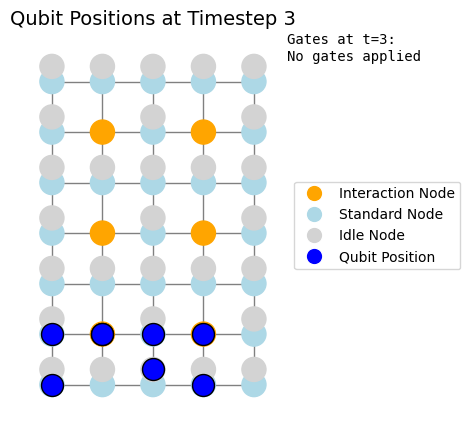

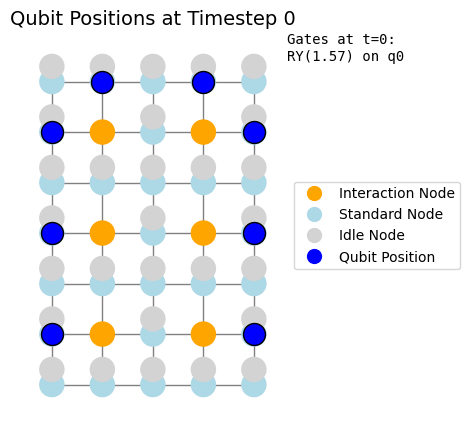

In [8]:

# %% [markdown]
# ## 6. Visualization (inline GIF)

# %% 
import matplotlib.pyplot as plt
plt.ioff()
from IPython.utils import io
from IPython.display import Image, display
from compiler.max import visualize_movement_on_trap

with io.capture_output():
    visualize_movement_on_trap(create_trap_graph(), positions, gates)
    plt.close("all")

display(Image("qubit_movement.gif"))